**Created on 05/01/2022**

**Group 2**

**Authors: LaurianeBompay**

**License: this code is released under the CeCILL 2.1 license. See
https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**


In [1]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
sns.set_style('darkgrid')

In [3]:
#data importation 
data_1 = pd.read_csv("newData.csv", index_col = 0)
#data_0 = pd.read_csv("positions.csv")

Il faudra changer l'imporation des données quand on aura le jeu de données avec les changements de repaires.

## <center>Remplacement des -inf</center>

In [4]:
data_1.replace([-np.inf], -120, inplace=True)

Les -inf sont dans les rssi et indique que le signal est très mauvais (ce n'est pas un nan) donc on remplace par -120 car c'est la valeur qui indique un mauvais signal (voir la doc sur les rssi)

In [5]:
data_1.describe()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,19730.000000,19730.000000,1.973000e+04,1.973000e+04,1.973000e+04,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,...,19730.000000,19730.000000,19730.000000,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000
mean,148.315256,7.215384,5.505930e+11,5.509284e+11,5.510320e+11,5.506966e+11,-2.755970,999.946275,1142.269047,4.690093,...,3.617079,39.577380,39.555326,1.654930e+12,2200.960720,-81.090100,-80.970815,-80.836828,-81.005838,106.200000
std,35.801496,19.474280,3.164088e+11,3.164091e+11,3.164091e+11,3.164088e+11,3.762077,674.275845,646.644922,3.162586,...,2.026579,2.341626,3.781826,3.017622e+05,1216.021329,5.635227,5.072462,4.817778,5.385790,61.171477
min,100.000000,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,...,0.000000,30.410000,27.559999,1.654930e+12,1.000000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,101.000000,2.956454,2.778599e+11,2.782487e+11,2.783513e+11,2.779625e+11,-5.783573,655.000000,715.849019,3.072176,...,1.899738,38.959999,36.680000,1.654930e+12,1174.000000,-79.967224,-79.988684,-79.884079,-79.886929,100.000000
50%,171.000000,3.524929,5.528798e+11,5.532044e+11,5.533074e+11,5.529824e+11,-1.784294,898.000000,998.316717,4.211930,...,3.699628,40.384998,39.340000,1.654930e+12,2231.500000,-79.230034,-79.305238,-79.218111,-79.237715,101.000000
75%,180.000000,4.342597,8.239225e+11,8.243395e+11,8.244432e+11,8.240262e+11,0.338401,1222.000000,1355.550936,5.731602,...,5.399282,41.240002,42.380001,1.654931e+12,3252.000000,-78.659592,-78.701023,-78.666953,-78.686635,150.000000
max,184.000000,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,12.363750,...,6.999961,42.380001,47.320004,1.654931e+12,4260.000000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


## <center>Test du modèle random forest pour determiner le position</center>

### Selection des variables pour la prédiction de position

In [6]:
data_for_pred = data_1.drop(['target',
                             'range',
                             'range_skew',
                             'ranging_error',
                             'distance',
                             'loc_target_z',
                             'timestamp',
                             'course_dist',
                             'temperature_initiator',
                             'temperature_target',
                             'seqnum'],axis=1, inplace=False)

On supprime course_dist car c'est équivalent à la localisation

In [7]:
var = data_for_pred.columns.to_list()
y=data_for_pred[['loc_initiator_x','loc_initiator_y']]

In [8]:
#ceration of test and train
test,train = train_test_split(data_for_pred, test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [9]:
X_train.describe()

,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,loc_target_x,loc_target_y,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,5919.000000,5.919000e+03,5.919000e+03,5.919000e+03,5.919000e+03,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000
mean,7.092815,5.490204e+11,5.493567e+11,5.494604e+11,5.491241e+11,-2.700063,999.420172,1138.849099,-0.921032,-0.790017,-81.035921,-80.935002,-80.802599,-80.956722,105.550262
std,18.616286,3.160009e+11,3.160010e+11,3.160010e+11,3.160009e+11,3.723144,667.191604,642.332581,8.066806,4.720162,5.543724,5.032963,4.814977,5.300372,61.698493
min,0.000000,6.268428e+08,8.283915e+08,9.327546e+08,7.312068e+08,-11.167219,-613.000000,-152.480214,-15.404000,-9.249000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,2.973421,2.775482e+11,2.780123e+11,2.781163e+11,2.776522e+11,-5.706664,644.000000,717.208556,-7.359000,-4.671000,-79.950134,-79.967225,-79.865237,-79.863833,100.000000
50%,3.545041,5.507730e+11,5.510722e+11,5.511748e+11,5.508764e+11,-1.815058,893.000000,994.030478,-0.830000,-1.546000,-79.220329,-79.306363,-79.231050,-79.245549,101.000000
75%,4.379286,8.237931e+11,8.242618e+11,8.243650e+11,8.238963e+11,0.369164,1217.000000,1342.679801,5.252000,3.318000,-78.654350,-78.701023,-78.667944,-78.679182,150.000000
max,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,15.404000,9.249000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


#### Premier modele avec toutes les variables

In [10]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)

In [11]:
reg.score(X_test,Y_test)

0.9784876749247335

In [12]:
mean_squared_error(Y_test,predic_rf)

0.3595911923818976

#### Affichage de ce premier modele

In [13]:
predic_position = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

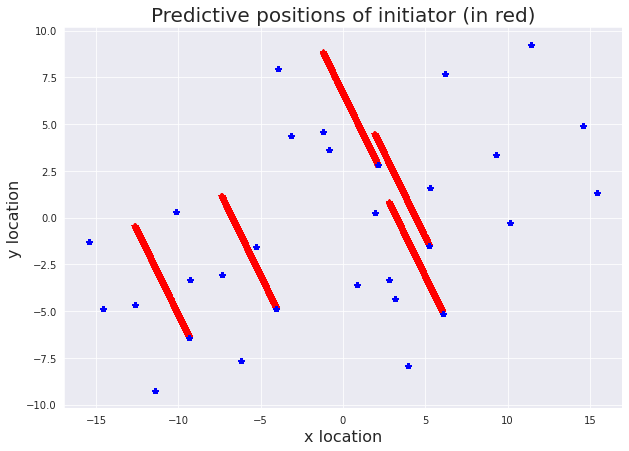

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position['loc_initiator_x'],predic_position['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

In [15]:
from sklearn.metrics import accuracy_score
list_variable=['nlos_indicator',
 't1',
 't2',
 't3',
 't4',
 'skew',
 'tof',
 'tof_skew',
 'loc_target_x',
 'loc_target_y',
 'rssi_request',
 'rssi_ack',
 'rssi_data',
 'rssi_mean',
 'repaire']
list_variable_tabou=list_variable
variable=[]
score=0
data_for_pred=data_for_pred.sample(frac=1).reset_index(drop=True)
while len(list_variable_tabou)>0:
    y=data_for_pred[['loc_initiator_x','loc_initiator_y']]
    variable_en_cour=False
    for i in list_variable_tabou:
        X=data_for_pred[variable+[i]]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        clf = RandomForestRegressor()
        clf= clf.fit(x_train, y_train)
        score_test=clf.score(x_test,y_test)
    if score_test>score:
        score=score_test
        variable_en_cour=i
    if variable_en_cour==False:
        list_variable_tabou=[]
    else:
        variable.append(variable_en_cour)
        del list_variable_tabou[list_variable_tabou.index(variable_en_cour)]
    print(variable_en_cour,score)

repaire 0.8770187191274795
False 0.8770187191274795


Cet algo me dit qu'il faut garder juste repaire mais ça semble faux

In [16]:
reg = RandomForestRegressor()
sfs = SequentialFeatureSelector(reg, direction='forward')
sfs.fit(X_train, Y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor())

In [17]:
var_select = sfs.get_support()
list_variable = X_train.columns.to_list()
for i in range(len(list_variable)) :
    if var_select[i]:
        print(list_variable[i])

nlos_indicator
skew
tof
tof_skew
loc_target_y
rssi_request
rssi_mean


#### Deuxième modèle avec les variables sélectionnées : nlos_indicator, skew, tof, tof_skew, loc_target_y, rssi_data,rssi_mean

In [18]:
#ceration of test and train with selected variables
test,train = train_test_split(data_for_pred[['nlos_indicator',
                                             'skew',
                                             'tof',
                                             'tof_skew',
                                             'loc_target_y',
                                             'rssi_data',
                                             'rssi_ack',
                                             'loc_initiator_x',
                                             'loc_initiator_y']], test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [19]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)
reg.score(X_test,Y_test)

0.9791166981028143

In [20]:
mean_squared_error(Y_test,predic_rf)

0.3513471193844245

In [21]:
predic_position_2 = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

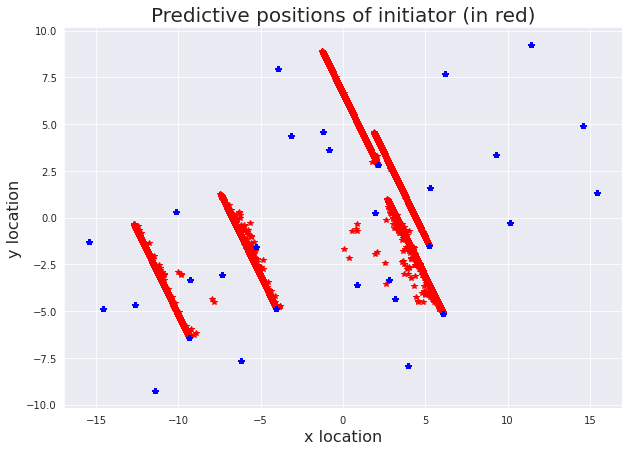

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position_2['loc_initiator_x'],predic_position_2['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

### Validation croisée

In [23]:
data_for_pred = data_for_pred[['nlos_indicator',
                                             'skew',
                                             'tof',
                                             'tof_skew',
                                             'loc_target_y',
                                             'rssi_data',
                                             'rssi_ack',
                                             'loc_initiator_x',
                                             'loc_initiator_y']] 

In [24]:
Y = data_for_pred[['loc_initiator_x', 'loc_initiator_y']]
X = data_for_pred.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [25]:
reg = RandomForestRegressor()
cross_val_score(reg, X, Y, cv=5)

array([0.98443626, 0.9829646 , 0.98623172, 0.98259152, 0.98364193])

## <center>Affichage du score de RandomForest en fonction des paramètres</center>

#### On va faire varier n_estimators qui correspond au nombre d'arbres de décisions utilisés.

In [98]:
scores_estimators = []

In [99]:
reg_50 = RandomForestRegressor(n_estimators = 1)
reg_50 = reg_50.fit(X_train, Y_train)
scores_estimators.append(reg_50.score(X_test,Y_test))

In [100]:
reg_100 = RandomForestRegressor(n_estimators = 100)
reg = reg_100.fit(X_train, Y_train)
scores_estimators.append(reg_100.score(X_test,Y_test))

In [101]:
reg_150 = RandomForestRegressor(n_estimators = 150)
reg_150 = reg_150.fit(X_train, Y_train)
scores_estimators.append(reg_150.score(X_test,Y_test))

In [102]:
reg_200 = RandomForestRegressor(n_estimators = 200)
reg_200 = reg_200.fit(X_train, Y_train)
scores_estimators.append(reg_200.score(X_test,Y_test))

In [103]:
scores_estimators

[0.9580796532519714, 0.9792745496220805, 0.9790015484894969, 0.979254249711405]

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different number of trees')

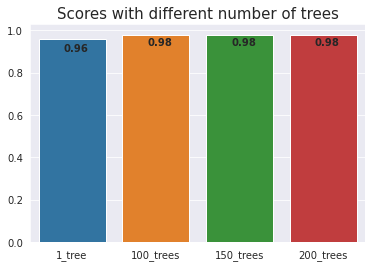

In [104]:
sns.barplot(['1_tree','100_trees','150_trees', '200_trees'],scores_estimators)
plt.text(-0.1, 0.9, round(scores_estimators[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9, 0.93, round(scores_estimators[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, 0.93, round(scores_estimators[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, 0.93, round(scores_estimators[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different number of trees",fontsize=15)

À partir de 100 arbres, le score ne change plus. 100 arbres est la valeur par défaut de RandomForest

#### On va faire varier max_depth qui correspond au nombre d'arbres de décisions utilisés.

In [133]:
scores_depth = []

In [134]:
reg_3 = RandomForestRegressor(max_depth = 3)
reg_3 = reg_3.fit(X_train, Y_train)
scores_depth.append(reg_3.score(X_test,Y_test))

In [135]:
reg_15 = RandomForestRegressor(max_depth = 6)
reg_15 = reg_15.fit(X_train, Y_train)
scores_depth.append(reg_15.score(X_test,Y_test))

In [136]:
reg_30 = RandomForestRegressor(max_depth = 9)
reg_30 = reg_30.fit(X_train, Y_train)
scores_depth.append(reg_30.score(X_test,Y_test))

In [137]:
reg_300 = RandomForestRegressor(max_depth = 12)
reg_300 = reg_300.fit(X_train, Y_train)
scores_depth.append(reg_300.score(X_test,Y_test))

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different maximum depth')

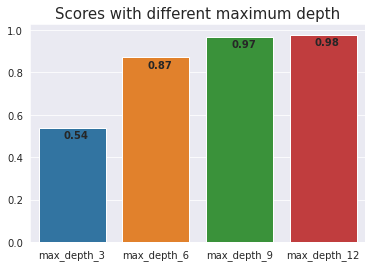

In [143]:
sns.barplot(['max_depth_3','max_depth_6','max_depth_9','max_depth_12'],scores_depth)
plt.text(-0.1, 0.49, round(scores_depth[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9, 0.82, round(scores_depth[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, 0.92, round(scores_depth[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, 0.93, round(scores_depth[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different maximum depth",fontsize=15)

#### On va faire varier max_depth et n_estimators en même temps

In [149]:
list_estimators = [1,100,150,200]
list_depth = [3,6,9,12]

In [175]:
dic_score = {} #{max_depth : n_estimators}
for i in range(len(list_estimators)):
    n_estimator = list_estimators[i]
    list_score = []
    for j in range(len(list_estimators)):
        max_depth = list_depth[j]
        reg = RandomForestRegressor(max_depth = max_depth,n_estimators=n_estimator)
        reg = reg.fit(X_train, Y_train)
        list_score.append(reg.score(X_test,Y_test))
    dic_score[n_estimator]=list_score

In [176]:
dic_score

{1: [0.5374360638584414,
  0.850973341941804,
  0.9573610306379156,
  0.95645495840773],
 100: [0.5393256665247159,
  0.8744808852248187,
  0.9690443960740771,
  0.9773960278264344],
 150: [0.5392552736169338,
  0.8732036951055284,
  0.9690428346195556,
  0.9775720923946046],
 200: [0.5392781006477553,
  0.8685924487275754,
  0.96924348792831,
  0.9774626399141917]}

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

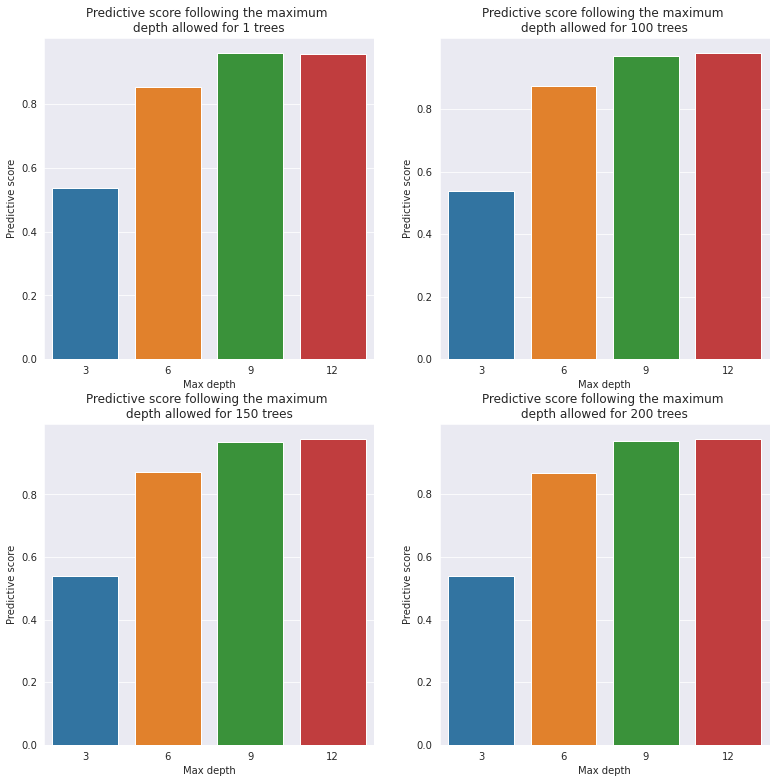

In [184]:
fig = plt.figure(figsize=(13,13))
i=1
for key in dic_score.keys() :
    ax = fig.add_subplot(2,2,i)
    bar1 = sns.barplot(list_depth,
                       dic_score[key])  
    ax.set_xlabel("Max depth")       
    ax.set_ylabel("Predictive score")     
    ax.set_yticks(np.arange(0, 1,0.2))       
    ax.set_title("Predictive score following the maximum \ndepth allowed for "+str(key)+" trees")   
    i+=1

Le maximum de profondeur a un effet sur la prédiction alors que le nombre d'arbre n'a pas beaucoup d'influence. Globalement, on observe la même évolution que ce soit pour 1 arbre ou 200 mais le score augment quand on augmente le maximum de profondeur.